In [71]:
import os
import smtplib
import requests
import pandas as pd
import numpy as np

from email.message import EmailMessage
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from bloxs import B

plt.style.use('ggplot')

_ = load_dotenv() 

In [72]:
crypto_symbol = "BTC"
crypto_symbol2 = "ETH"

In [81]:
def display_crypto_data(p_crypto_simbol, p_crypto, p_crypto_simbol2, p_crypto2):
    try:
        ##### plot finance charts
        fig, ax = plt.subplots(1, 2, figsize=(17,5))

        _=ax[0].plot(p_crypto.Close, color="orange", linewidth=3)
        ax[0].title.set_text(p_crypto_simbol)
        ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        _=ax[0].set_ylabel("USDT")

        _=ax[1].plot(p_crypto2.Close, color="green", linewidth=3)
        ax[1].title.set_text(p_crypto_simbol2)
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
        _=ax[1].set_ylabel("USDT")
    except Exception as e:
        print(str(e))

In [ ]:
####### get crypto data from Binance REST API
def get_crypto_data(p_symbol,p_interval, p_limit):
    try:
        response = requests.get(f"https://www.binance.com/api/v1/klines?symbol={p_symbol}&interval={p_interval}&limit={p_limit}")
        candles = response.json()
        df = pd.DataFrame(candles, columns=["Open time", "Open", "High", "Low", "Close", "Volume", 
                                        "Close time", "Quote", "Trades", "BaseVol", "QuoteVol", "Igonre"])
        df["Date"] = pd.to_datetime(df["Open time"], unit='ms')
        for col in ["Open", "High", "Low", "Close", "Volume"]:
            df[col] = df[col].astype(float)
        df = df.set_index('Date')
        return df
    except Exception as e:
        print(str(e))
        return None

In [73]:
##### CLASSES EMAILSERVICE
class EmailService:
    def __init__(self):
        self.address = os.environ.get("EMAIL_ADDRESS")
        self.password = os.environ.get("EMAIL_PASSWORD")
        
    def send(self, to_address, subject, message):
        msg = EmailMessage()
        msg['Subject'] = subject
        msg['From'] = self.address
        msg['To'] = to_address
        msg.set_content(message)
        
        with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
            smtp.login(self.address, self.password)
            smtp.send_message(msg)

In [115]:
##### CLASSES Crypto
class Crypto:
    def __init__(self, symbol, interval ="1d", limit = 30):
        self.symbol = symbol
        #self.address = os.environ.get("EMAIL_ADDRESS")
        #self.password = os.environ.get("EMAIL_PASSWORD")
        self.interval = interval
        self.limit = limit

    def refresh_data(self, interval, limit):
        self.interval = interval
        self.limit = limit
        return self.refresh_data()

    def refresh_data(self):
        try:
            #print(f"Refresh Data {self.symbol} {self.interval} {self.limit}")
            response = requests.get(f"https://www.binance.com/api/v1/klines?symbol={self.symbol}&interval={self.interval}&limit={self.limit}")
            candles = response.json()
            #print(f"Refresh Data2 {response.json()}")
            self.data = pd.DataFrame(candles, columns=["Open time", "Open", "High", "Low", "Close", "Volume", 
                                            "Close time", "Quote", "Trades", "BaseVol", "QuoteVol", "Igonre"])
            self.data["Date"] = pd.to_datetime(self.data["Open time"], unit='ms')
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                self.data[col] = self.data[col].astype(float)
            self.data = self.data.set_index('Date')
            
            return True
        except Exception as e:
            print(str(e))
            return False        

    
    def plot(self):
        try:
            ##### plot charts
            fig, ax = plt.subplots(1, 1, figsize=(17,5))

            _=ax[0].plot(self.data.Close, color="orange", linewidth=3)
            ax[0].title.set_text(self.simbol)
            ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
            _=ax[0].set_ylabel("USDT")

        except Exception as e:
            print(str(e))

    def subplot(self, crypto2):
        try:
            plt.style.use('ggplot')
            ##### plot finance charts
            fig, ax = plt.subplots(1, 2, figsize=(17,5))

            _=ax[0].plot(self.data.Close, color="orange", linewidth=3)
            ax[0].title.set_text(self.symbol)
            ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
            _=ax[0].set_ylabel("USDT")

            _=ax[1].plot(self.data.Close, color="green", linewidth=3)
            ax[1].title.set_text(self.symbol)
            ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
            _=ax[1].set_ylabel("USDT")
        except Exception as e:
            print(str(e))

In [122]:
objCrypto1 = Crypto(f"{crypto_symbol}USDT")
objCrypto2 = Crypto(f"{crypto_symbol2}USDT")

In [123]:
objCrypto1.refresh_data()
objCrypto2.refresh_data()

True

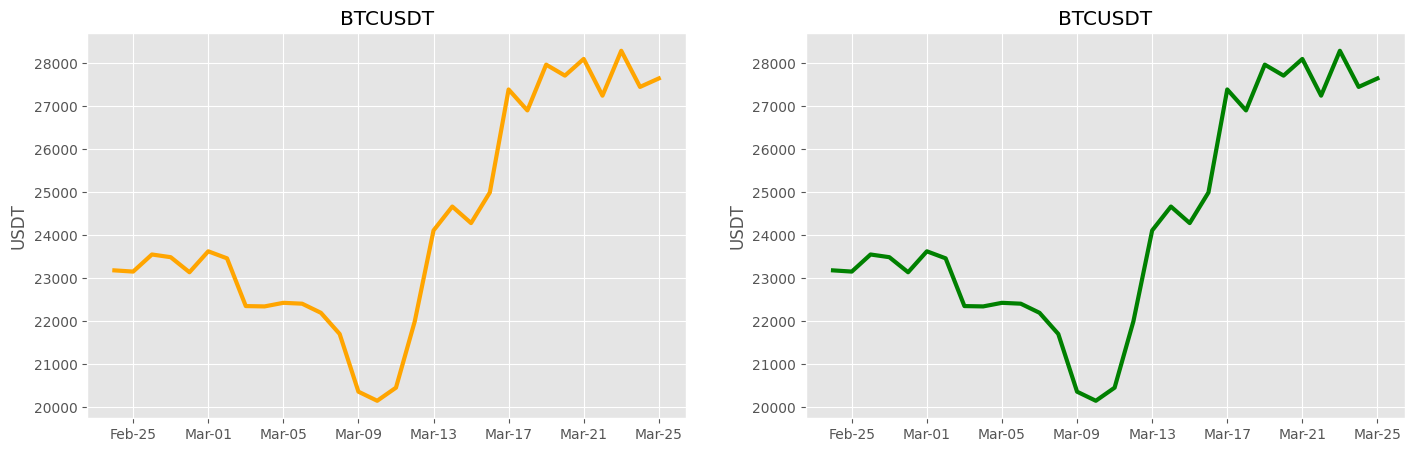

In [124]:
objCrypto1.subplot(objCrypto2)

In [80]:
# Vecchio approccio
# Day intervals
crypto_day   = get_crypto_data(f"{crypto_symbol}USDT"  , "1d", 30)
crypto_day2  = get_crypto_data(f"{crypto_symbol2}USDT", "1d", 30)
# Hour Intervals
crypto_hour  = get_crypto_data(f"{crypto_symbol}USDT"  , "1h", 30)
crypto_hour2 = get_crypto_data(f"{crypto_symbol2}USDT", "1h", 30)

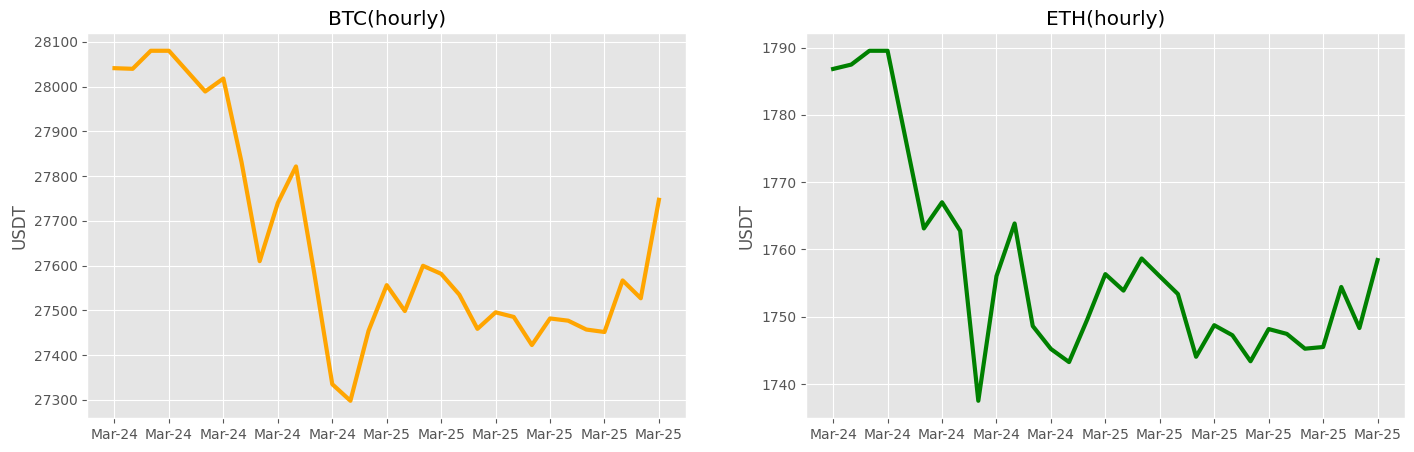

In [82]:
##### Display charts
display_crypto_data(crypto_symbol+"(hourly)",crypto_hour,crypto_symbol2+"(hourly)",crypto_hour2)

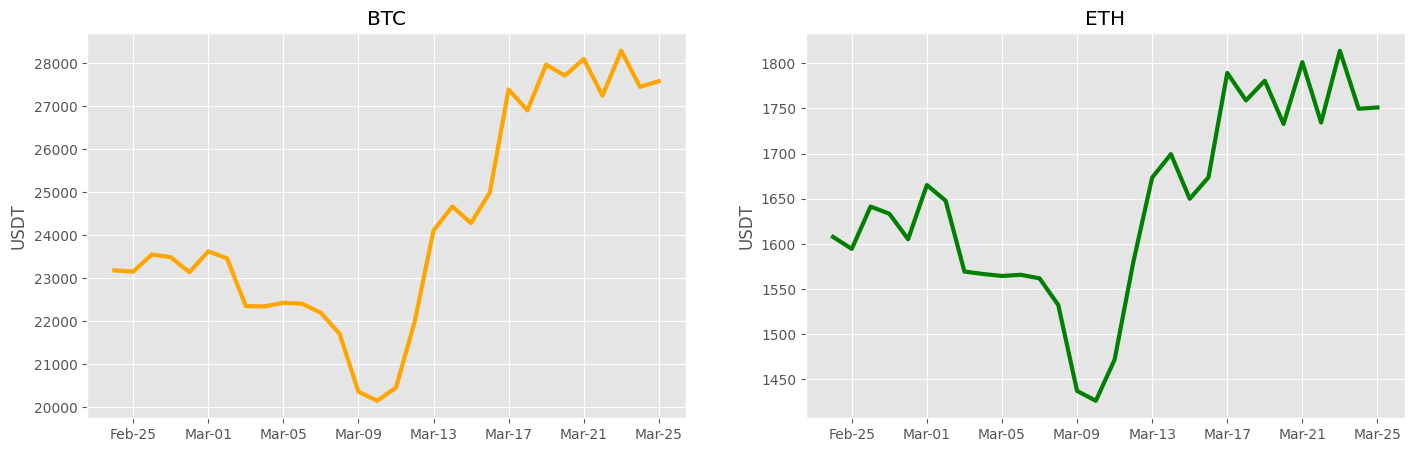

In [12]:
##### Display charts
display_crypto_data(crypto_symbol,crypto_day,crypto_symbol2,crypto_day2)

In [61]:
###### alerts

In [13]:
crypto_change = (crypto_day.tail(7).Close.max() - crypto_day.tail(7).Close.min())/crypto_day.tail(7).Close.max()
crypto_change2 = (crypto_day2.tail(7).Close.max() - crypto_day2.tail(7).Close.min())/crypto_day2.tail(7).Close.max()

In [14]:
if crypto_change > 0.3: # crypto change over 30% send email notification
    EmailService().send("ithinkdiabolik@gmail.com", 
        "Crypto price large change alert", 
        f"Large price change ({np.round(crypto_change*100.0,2)}%) of {crypto_symbol} in the last 7 days.")
    
if crypto_change2 > 0.3: # crypto change over 30% send email notification
    EmailService().send("ithinkdiabolik@gmail.com", 
        "Crypto price large change alert", 
        f"Large price change ({np.round(crypto_change2*100.0,2)}%) of {crypto_symbol2} in the last 7 days.")

In [15]:
B([
    #B(f"{np.round(stock_change*100, 2)}%", f"{stock_symbol} week change"),
    B(f"{np.round(crypto_change*100, 2)}%", f"{crypto_symbol} week change"),
    B(f"{np.round(crypto_change2*100, 2)}%", f"{crypto_symbol2} week change"),
    #B(meteo.windgusts_10m.max(), f"Max wind gusts"),
])

In [16]:
B([
    #B(stock_hist.Close[-1].astype(int), f"{stock_symbol}"),
    B(crypto_day.Close[-1].astype(int), f"{crypto_symbol}"),
    B(crypto_day2.Close[-1].astype(int), f"{crypto_symbol2}"),
    #B(meteo.temperature_2m.max(), f"Max Temp"),
])